# Candles

Check out the readme in this directory for further explanations

In [1]:
import alpaca_trade_api as tradeapi
from datetime import datetime
import pytz
tzET = pytz.timezone('US/Eastern')
import math

import matplotlib.pyplot as plt
plt.rcParams['timezone'] = 'US/Eastern'
import matplotlib.dates as mdates # for formatting dates in graph
from matplotlib.lines import Line2D # legend

import pandas as pd
import numpy as np

In [2]:
# returns public and secure key from alpaca and paper trading url
# these should really be stored securely in a different file
def getKeys():
  pub = 'PKJ0P4P4I3IKN3EM29U0'
  sec = 'x3FGUvHqQEGCHHAClL10O3C6Ywo6NGgmbwXtBmwp'
  url = 'https://paper-api.alpaca.markets' # in production remove 'paper-'
  return pub, sec, url

In [3]:
# starts up alpaca account and prints the portfolio cash
def initAlpaca():
  global api

  import alpaca_trade_api as tradeapi
  import websocket

  # START UP ACCOUNT
  public, secret, url = getKeys()
  api = tradeapi.REST(public, secret, url, api_version='v2')
  account = api.get_account()
  assert(account.status == 'ACTIVE')

In [4]:
# gets minute bars/candles for the stock with specific symbol between two iso dates
def getBarsForStockBetween(symbol, startIso, endIso):
  barset = api.get_barset(
    symbol, 
    'minute',
    start=startIso,
    end=endIso,
  )[symbol]
  for b in barset:
    b.t = b.t.astimezone(tzET)
  return barset

In [5]:
def roundDown(input, dp):
  factor = 10 ** dp
  return math.floor(input * factor)/factor

def roundUp(input, dp):
  factor = 10 ** dp
  return math.ceil(input * factor)/factor

In [6]:
def prettyDate(iso):
  return datetime.fromisoformat(iso).strftime("%Y-%m-%d %H:%M")

In [7]:
# Runs the strategy for the specific red and green runs
def applyStrategyCandles(bars, initialCash, runLimitRed, runLimitGreen):

  cash = initialCash # the spare "spending" money
  assets = 0 # what all shares are worth
  total = cash + assets # sum of cash and assets
  runRed = 0   # number of red   candles that have appeared in a row
  runGreen = 0 # number of green candles that have appeared in a row
  qty = 1 # the max quantity of shares to have at any time starts at 1
  isStockBought = False

  priceBuy  = 0
  priceStop = 0

  priceEntryList = [] # start end priceBuy priceStop 
  priceEntryRow = [0, 0, 0, 0]
  
  priceExitList = [] # time priceBuy priceProfit
  listTotals = [] # time total priceBlind

  # make the blind investment (for investment only at start)
  priceBlind = initialCash
  buyBlind = bars[0].c

  for bar in bars:

    isGreen = bar.c > bar.o
    isRed = bar.o > bar.c
    isDoji = not isGreen and not isRed

    # buy when: candle turns green after runLimitRed or more reds
    if not isStockBought:
      if runRed >= runLimitRed:
        if isGreen:
          # BUYING

          qty = math.floor(total / bar.c) # buy the most shares possible
          if qty == 0:
            print('You cant afford a share lol...')
        
          priceBuy = bar.c
          cost = qty * priceBuy
          if cash - cost < 0:
            print('***BROKE*** ):')
            break
          
          cash -= cost
          assets += cost # note total stays the same
          
          priceStop = priceBuy * (1 - 0.005)
          isStockBought = True
          
          # for plotting
          priceEntryRow = [bar.t, 0, priceBuy, priceStop]
            
    # sell at the stop price
    if isStockBought:
      if bar.l < priceStop:
        # SELLING at stop price

        cash += qty * priceStop
        assests = 0
        total = cash + assests

        isStockBought = False

        priceEntryRow[1] = bar.t
        priceEntryList.append(priceEntryRow)
        priceEntryRow = [0, 0, 0, 0]

        priceExitList.append([bar.t, priceBuy, priceStop])
      
      elif isRed and runGreen >= runLimitGreen and bar.c > priceBuy:
        # sell for profit when: candle turns red after runLimitGreen or more green and not a loss
        # SELLING
        
        cash += qty * bar.c
        assests = 0
        total = cash + assests
        
        isStockBought = False

        priceEntryRow[1] = bar.t
        priceEntryList.append(priceEntryRow)
        
        priceEntryRow = [0, 0, 0, 0]

        priceExitList.append([bar.t, priceBuy, bar.c])
      
      else:
        # if no sold, increase the portfolio total (also runs after buying but makes no difference)
        assests = qty * bar.c
        total = cash + assests

    # change run counts
    if isRed:
      runRed += 1
      runGreen = 0
    if isGreen:
      runGreen += 1
      runRed = 0

    priceBlind = initialCash * bar.c / buyBlind
    listTotals.append([bar.t, total, priceBlind])

  # if the last shares have not been sold
  if isStockBought:
    priceEntryRow[1] = bars[-1].t
    priceEntryList.append(priceEntryRow)
    # priceEntryRow = [0, 0, 0, 0] # todo not needed

  priceLinesDF = pd.DataFrame(priceEntryList, columns=['start', 'end', 'priceBuy', 'priceStop'])
  profitLinesDF = pd.DataFrame(priceExitList, columns=['time', 'priceBuy', 'priceProfit'])
  totalsDF = pd.DataFrame(listTotals, columns=['time', 'total', 'priceBlind'])
  return priceLinesDF, profitLinesDF, totalsDF, total

In [8]:
# plots the color map showing interest earned for each strategy
def plotColorMap(initialCash, totals, symbol, minSize, startIso, endIso):
  fig, ax = plt.subplots(figsize=(6, 6))
  
  labelIndices = []
  labels = []
  
  for i in range(len(totals)):
    for j in range(len(totals[i])):
      totals[i][j] = 100 * totals[i][j] / initialCash - 100

  matrixNP = np.array(totals)
  cax = ax.matshow(matrixNP, cmap=plt.cm.Blues)
  for i in range(len(totals)):
    labelIndices.append(i)
    labels.append(minSize + i)
    for j in range(len(totals)):
      ax.text(
        i, j, 
        str(roundUp(matrixNP[j,i], 2)), 
        va='center', ha='center'
      )

  plt.suptitle('Colourmap Strategies', size=16, y=1.05)
  plt.title('Percent Interest for stock: ' + symbol + ' between: ' + prettyDate(startIso) + ' and ' + prettyDate(endIso) + '\n'\
          'Buying on the first green after "Red run" reds and selling after the ' +\
          'first red after "Green run" greens')
  plt.xlabel('Green run (needed for selling)')
  plt.ylabel('Red run (needed for buying)')
  
  fig.colorbar(cax, fraction=0.046, pad=0.04)
  
  ax.set_xticks(labelIndices)
  ax.set_yticks(labelIndices)
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  plt.show()

In [9]:
def plotCandleStrategy(bars, priceLinesDF, profitLinesDF, totalsDF, initialCash, greenRuns, redRuns, isDrawingCandles):
  # Plotting
  fig, ax = plt.subplots(2, sharex=True, figsize=(14, 7))
  
  # blue is the investment on candle patterns
  ax[0].plot(totalsDF.time, totalsDF.total, color='b') 
  
  # black is the blind investment
  ax[0].plot(totalsDF.time, totalsDF.priceBlind, color='k')
  
  # green is for no investment
  ax[0].plot([totalsDF.time[0], list(totalsDF.time)[-1]], [initialCash, initialCash], color='green')

  listDates = [] # todo change to listDates
  listOpen = []
  listClose = []
  listHigh = []
  listLow = []

  for b in bars:
    listDates.append(b.t)
    listOpen.append(b.o)
    listClose.append(b.c)
    listHigh.append(b.h)
    listLow.append(b.l)

  if isDrawingCandles:

    prices = pd.DataFrame(index=listDates)
    prices['Open'] = listOpen
    prices['High'] = listHigh
    prices['Low'] = listLow
    prices['Close'] = listClose

    pricesup   = prices[prices.Close >= prices.Open]
    pricesdown = prices[prices.Close <  prices.Open]

    width  = 0.9 * (1 / prices.shape[0]) / 20 # width of candle
    width2 = 0.1 * (1 / prices.shape[0]) / 30 # width of wick
    
    # plot the candles
    # green
    greenBarheight = [] # bar has a minimum thickness to ensure it shows up
    for index, row in pricesup.iterrows():
      height = row.Close - row.Open
      if height < 0.01 and height > -0.01:
        height = 0.01
      greenBarheight.append(height)
    ax[1].bar(pricesup.index, greenBarheight, width, bottom=pricesup.Open, color='g')
    ax[1].bar(pricesup.index, pricesup.High - pricesup.Low, width2, bottom=pricesup.Low, color='g')
    # red
    redBarheight = []
    for index, row in pricesdown.iterrows():
      height = row.Close - row.Open
      if height < 0.01 and height > -0.01:
        height = 0.01
      redBarheight.append(height)
    ax[1].bar(pricesdown.index, redBarheight, width, bottom=pricesdown.Open, color='r')
    ax[1].bar(pricesdown.index, pricesdown.High - pricesdown.Low, width2, bottom=pricesdown.Low, color='r')
  
  # trade entry/exit
  isDrawingProfitSymbols = True
  if isDrawingProfitSymbols:
    for index, row in priceLinesDF.iterrows():
      ax[1].plot([row.start, row.end], [row.priceBuy, row.priceBuy], color='b') # enter trade
      ax[1].plot([row.start, row.end], [row.priceStop, row.priceStop], color='orange') # stop loss
    for index, row in profitLinesDF.iterrows():
      ax[1].plot([row.time, row.time], [row.priceBuy, row.priceProfit], color='b') # exit trade
  
  # plot only 40 ticks
  listDatesForTicks = []
  if len(listDates) > 40:
    tickFreq = roundUp(len(listDates) / 40, 0)
    for i, date in enumerate(listDates):
      if i % tickFreq == 0:
        listDatesForTicks.append(date)
  else:
    listDatesForTicks = listDates
  plt.xticks(listDatesForTicks)
  
  # format tick dates
  ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %I:%M %p'))
  plt.xticks(rotation=90)
  fig.tight_layout()
  
  # title
  strategyName = str(redRuns) + ' redRuns and ' + str(greenRuns) + ' greenRuns'
  ax[0].set_title('Investment Outcomes including strategy: ' + strategyName, size=16, y=1.12)
  ax[1].set_title('Candleplot and Trades', size=16, y=1.12)
  
  # space to next axis
  box = ax[0].get_position()
  ax[0].set_position([box.x0, box.y0*1.2, box.width, box.height])
  
  # legends
  legend_elements = [
    Line2D([0], [0], color='green', lw=4, label='No Investment'),
    Line2D([0], [0], color='black', lw=4, label='Initial Investment Only'),
    Line2D( [],  [], color='blue' , lw=4, label='Investment using strategy')
  ]
  ax[0].legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), borderaxespad=0, ncol=3)
  legend_elements = [
    Line2D([0], [0], color='blue', lw=4, label='Start/end close price of the trade'),
    Line2D([0], [0], color='orange', lw=4, label='Stop Loss'),
  ]
  ax[1].legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), borderaxespad=0, ncol=3)
  
  plt.grid()
  plt.show()

In [10]:
def viewBullsBears(symbol, startIso, endIso, isDrawingCandles):
  initialCash = 10000

  bars = getBarsForStockBetween(symbol, startIso, endIso)
  totals = []
  
  # size of the colormap
  minSize = 2
  maxSize = 8
  # the strategy used in the plots
  strategyRed   = 3 
  strategyGreen = 3
  priceLinesDF_strategy = None
  profitLinesDF_strategy = None
  totalsDF_strategy = None
  
  for runLimitRed in range(minSize, maxSize + 1): # how many bears/reds are needed before a buy
    # red is on the vertical axis
    totalsRow = []
    for runLimitGreen in range(minSize, maxSize + 1): # how many bulls/greens are needed before a sell
      if len(bars) > 0:
        priceLinesDF, profitLinesDF, totalsDF, total = applyStrategyCandles(bars, initialCash, runLimitRed, runLimitGreen)
        # save the dataframes for the strategy in the plot
        if(runLimitRed == strategyRed and runLimitGreen == strategyGreen):
          priceLinesDF_strategy  = priceLinesDF
          profitLinesDF_strategy = profitLinesDF
          totalsDF_strategy      = totalsDF
      else:
        print('ERROR: '+ symbol + ' has no bars !')
        return 0
      totalsRow.append(total)
    
    totals.append(totalsRow)
  
  plotColorMap(initialCash, totals, symbol, minSize, startIso, endIso)
  
  if not priceLinesDF_strategy.empty:
    plotCandleStrategy(bars, priceLinesDF_strategy, profitLinesDF_strategy, totalsDF_strategy, \
               initialCash, strategyGreen, strategyRed, isDrawingCandles)

# Results

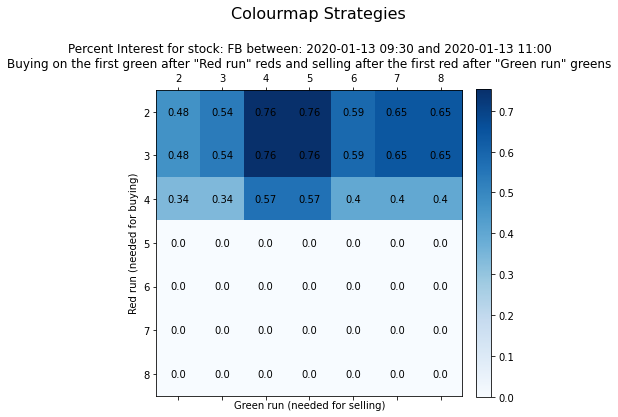

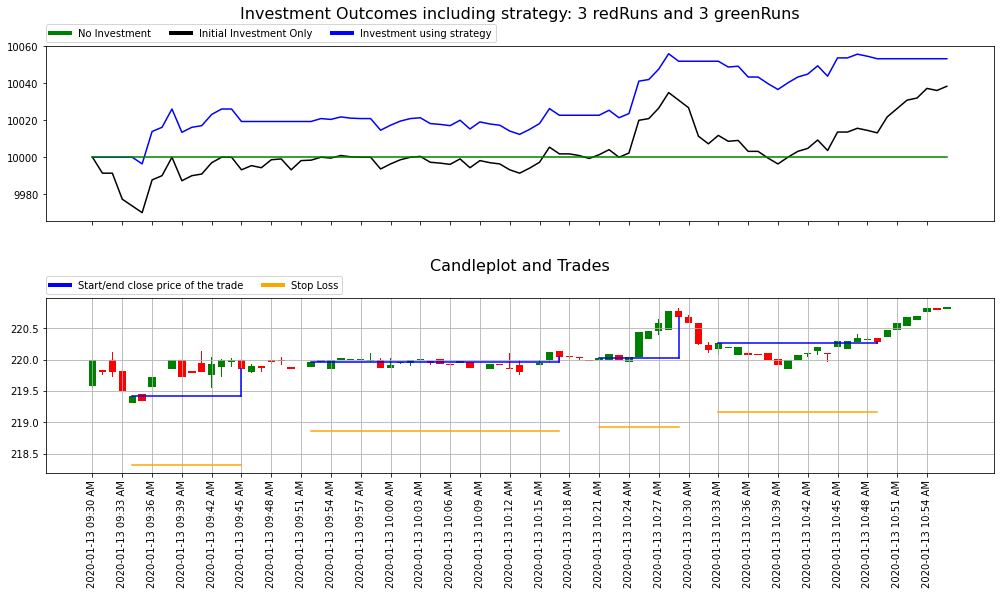

In [11]:
initAlpaca()
viewBullsBears(
  'FB',
  datetime(2020, 1, 13,  9, 30, 0, tzinfo=tzET).isoformat(),
  datetime(2020, 1, 13, 11, 0, 0, tzinfo=tzET).isoformat(),
  True
)

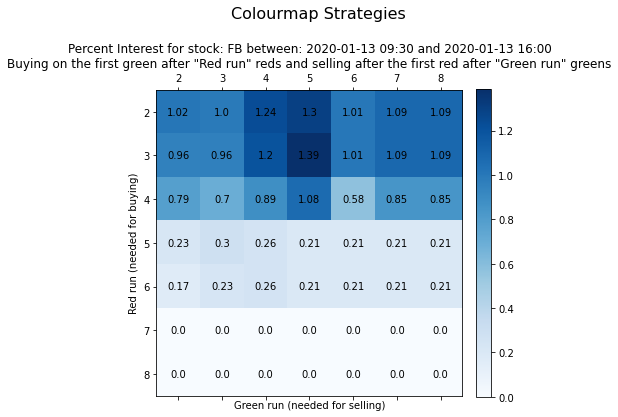

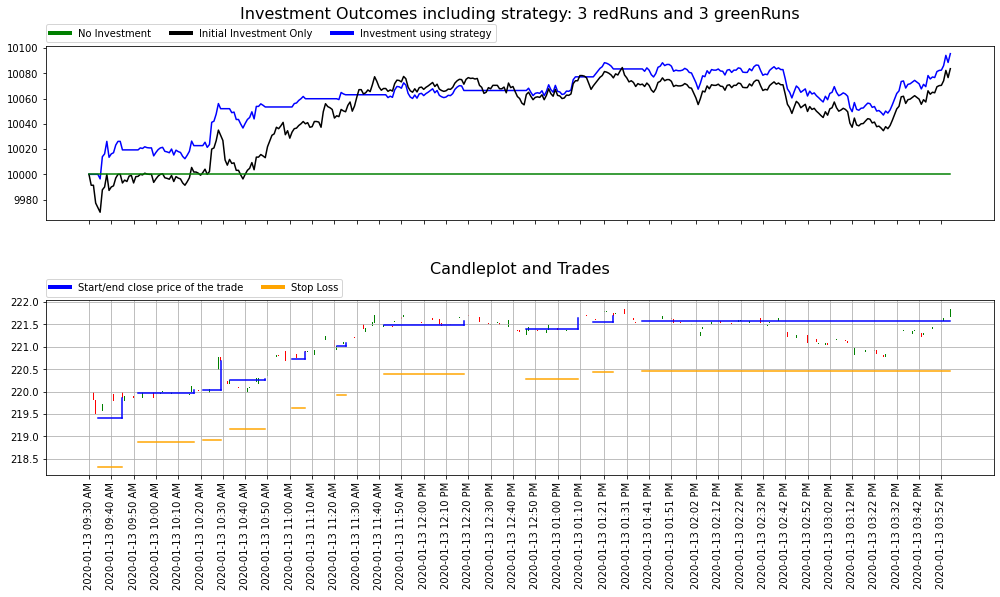

In [12]:
initAlpaca()
viewBullsBears(
  'FB',
  datetime(2020, 1, 13, 9, 30, 0, tzinfo=tzET).isoformat(),
  datetime(2020, 1, 13, 16, 0, 0, tzinfo=tzET).isoformat(),
  True
)

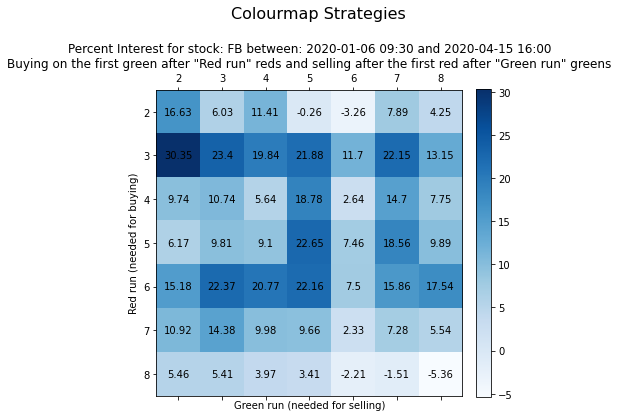

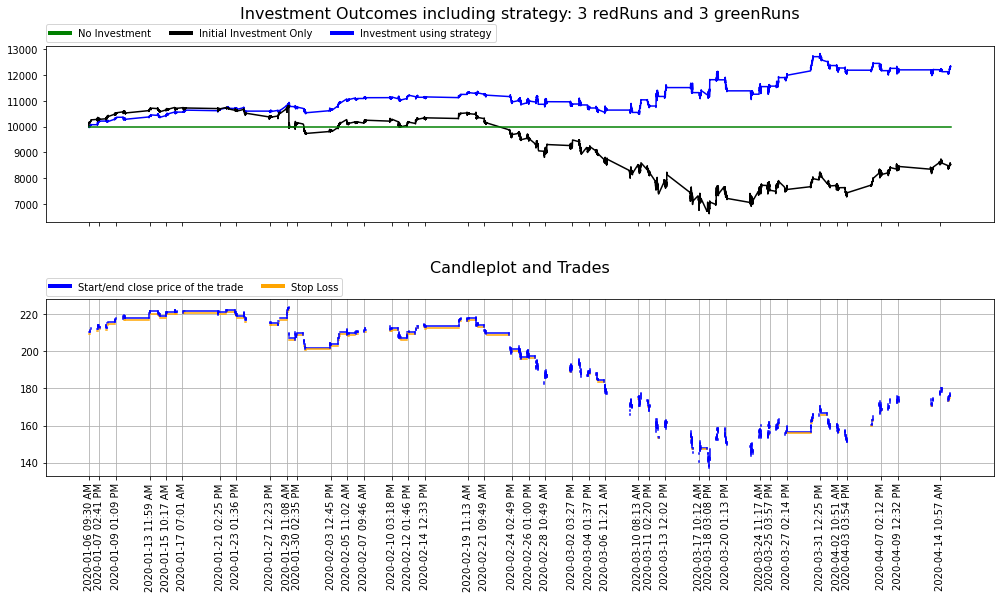

In [13]:
initAlpaca()
viewBullsBears(
  'FB',
  datetime(2020, 1,  6, 9, 30, 0, tzinfo=tzET).isoformat(),
  datetime(2020, 4, 15, 16, 0, 0, tzinfo=tzET).isoformat(),
  False
)